# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be another multiple things as the options).

## 1. Make classification data and get it ready

We'll use the [make_circles()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots.

> Indented block



In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same 

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                     "X2": X[:, 1],
                     "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


It looks like each pair of `X` features (`X1` and `X2`) has a label (`y`) value of either 0 or 1.

This tells us that our problem is **binary classification** since there's only two options (0 or 1).

How many values of each class is there?

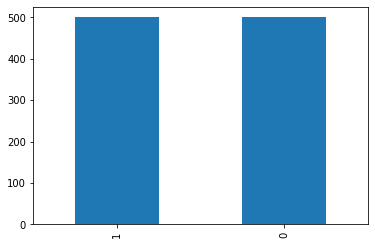

In [6]:
circles.label.value_counts().plot(kind='bar')

500 each, nice and balanced

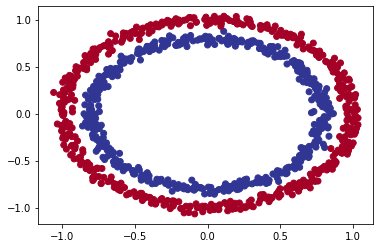

In [7]:
# Visualize our data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a **toy dataset**, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:

1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).

2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [10]:
import torch
torch.__version__

'1.12.1+cu113'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use a helper function [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from Scikit-Learn.

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 80% for training set and 20% for test set
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Nice, Looks like we've now got 800 training samples and 200 testing samples.

## 2. Building a model

Let's build a model to classify our blue or red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`).
3. Define a loss function and optimizer.
4. Create a training and testing loop.

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create two `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instantiate an instance of our model class and send it to the target device.

In [17]:
# 1. Construct the model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X) and upscales to 5 features.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2

# 4. Instantiate an instance of our model class and send it to the target device.
model_0 = CircleModelV0()
model_0.to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

You can also do the same as above using [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [20]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

That looks much simpler than subclassing `nn.Module`, why not just always use `nn.Sequential`?

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it *always* run as sequential order.

In [21]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.2284, -0.5107],
                      [-0.1740,  0.4887],
                      [-0.3111, -0.1771],
                      [ 0.5279, -0.0149],
                      [ 0.5842, -0.6987]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0102, -0.0889, -0.5033, -0.4292, -0.2529], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2061, -0.3694, -0.4092,  0.3035,  0.4033]], device='cuda:0')),
             ('1.bias', tensor([0.2313], device='cuda:0'))])

In [22]:
# Make predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [-0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


It seems there's the same amount of predictions as there is test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.

### 2.1 Setup loss function and optimizer

Which loss function and optimizer should we use ?

For example for **regression**, we can use **MAE** or **MSE** (Mean Absolute Error or Mean Squared Error).

For example for **classification**, we might want **binary cross entropy** or **categorical cross entropy** (cross entropy).

As a reminder, a loss function measures how *wrong* our models predictions are.

And for optimizers, two of the most common and useful are **SGD (Stochastic Gradient Descent)** and **Adam**, however PyTorch has many built-in functions.

- For the loss function, we're going to use `torch.nn.BCEWithLogitsLoss()`. **BCE** stands for **Binary Cross Entropy.**
- For different optimizers, see `torch.optim`.

In [25]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [26]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right ?
# Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true)) * 100
  return acc

We can now use this function while training our model to measure it's performance alongside the loss.

## 3. Train model

To  train our model, we're going to need to build a training loop with the following step:

1. Forward pass.
2. Calculate the loss.
3. Optimizer zero grad.
4. Loss backward (backpropagation).
5. Optimizer step (gradient descent).

### 3.1 Going from raw model output to prediccted labels (logits -> probabilities -> prediction labels)

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. `sigmoid` for binary classification and `softmax` for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax`.

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1644],
        [-0.0336],
        [-0.0530],
        [-0.1979],
        [ 0.6682]], device='cuda:0')

In [28]:
y_test[:5] # Our logits are not in the same format as our y_test variable

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs 

tensor([[0.4590],
        [0.4916],
        [0.4867],
        [0.4507],
        [0.6611]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

- `y_pred_probs` >=0.5, `y=1` (class 1)
- `y_pred_probs` <0.5, `y=0` (class 0)

In [32]:
# Find the predicted labels (round the prediction probablities)
y_preds = torch.round(y_pred_probs)

# In full (logits -> preb probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([False, False,  True, False, False], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

Excellent! Now it looks like our model's predictions are in the same form as our truth labels (`y_test`).

### 3.2 Building a training and testing loop

In [31]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra 1 dimensions
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)
  loss = loss_fn(y_logits, # This function expect raw logits as input because we are using nn.BCELossLogitsLoss()
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
   
  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71976, Acc: 50.38% | Test Loss: 0.71499, Test acc: 55.50%
Epoch: 10 | Loss: 0.71008, Acc: 50.25% | Test Loss: 0.70780, Test acc: 54.50%
Epoch: 20 | Loss: 0.70455, Acc: 50.75% | Test Loss: 0.70386, Test acc: 54.00%
Epoch: 30 | Loss: 0.70111, Acc: 50.38% | Test Loss: 0.70152, Test acc: 52.00%
Epoch: 40 | Loss: 0.69885, Acc: 49.88% | Test Loss: 0.70003, Test acc: 52.00%
Epoch: 50 | Loss: 0.69731, Acc: 50.25% | Test Loss: 0.69906, Test acc: 52.00%
Epoch: 60 | Loss: 0.69623, Acc: 50.50% | Test Loss: 0.69840, Test acc: 51.50%
Epoch: 70 | Loss: 0.69545, Acc: 50.50% | Test Loss: 0.69794, Test acc: 51.50%
Epoch: 80 | Loss: 0.69489, Acc: 50.12% | Test Loss: 0.69760, Test acc: 49.00%
Epoch: 90 | Loss: 0.69447, Acc: 50.88% | Test Loss: 0.69735, Test acc: 49.00%
Epoch: 100 | Loss: 0.69416, Acc: 50.75% | Test Loss: 0.69716, Test acc: 49.00%
Epoch: 110 | Loss: 0.69393, Acc: 51.38% | Test Loss: 0.69700, Test acc: 49.00%
Epoch: 120 | Loss: 0.69375, Acc: 51.25% | Test Loss: 0.69687, T

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing.

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it, let's make some predictions and then visualize!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [33]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


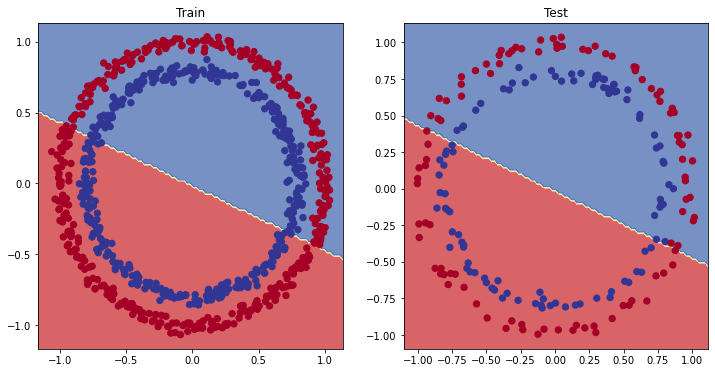

In [34]:
# Plot decision boundary of the model for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

How could we improve this?

## 5. Improving a model (from a model perspective)

Focusing specially on the model (not the data), there are a few ways we could do this.

- **Add more layers** - give the model more chances to learn about patterns in the data.
- **Add more hidden units** - go from 5 hiddens units to 10 hidden units.
- **Fit for longer** (Our model might learn more if it had more opportunities to look at the data.)
- **Changing the activation functions** - Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this.
- **Change the learning rate** - the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.
- **Change the loss function** - Again, less model specific but still important, different problems require different loss functions. 
- ** Use transfer learning** - Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. 

These options are all from a model perspective because they deal directly with the model, rather than the data.

And because these options are all values, we (as a machine learning engineers and data scientists) can change, they referred as **hyperparameters**.

Let's try and improve our model by:
- Adding more hidden units: 5 -> 10
- Increase the number of layers: 2 -> 3
- Increase the number of epochs: 1000 -> 2000

We will follow the same steps we did above but with a few changed hyperparameters.

In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverage speed ups where possible behind the scene

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [38]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer and see if it improves our model
epochs = 2000

# Put data on the device target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilities predictions -> ppredictions labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimier zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  ### Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 100 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 200 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1000 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1100 | Loss: 0.69298, acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1200 | Loss: 0.69298, acc: 51.00% | Test loss

Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

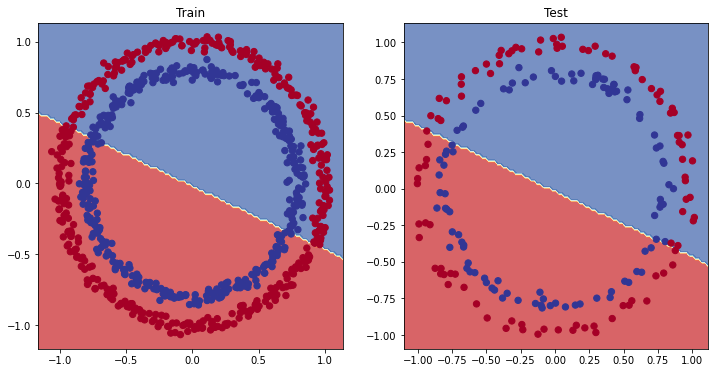

In [39]:
# Plot decision boundary of our new model (model_1) for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [40]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lenghts of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

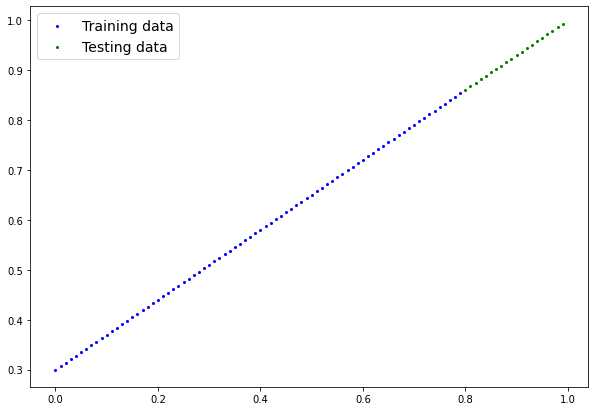

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

Now we've got some data, let's recreate `model_1` but with a loss function suited to our regression data.

In [42]:
# Same archtecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

We'll setup the loss function to be `nn.L1Loss()` (the same as mean absolute error) and the optimizer to be `torch.optim.SGD().`

In [43]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [51]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Trainning
for epoch in range(epochs):
  # Training mode
  model_2.train()

  # 1. Forward pass
  y_pred = model_2(X_train_regression)
 
  # 2. Calculate Loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Evaluation mode
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_2(X_test_regression)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test_regression)
  
  # Print out what's happenning
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.01027 | Test loss: 0.03325
Epoch: 100 | Train Loss: 0.01061 | Test loss: 0.03365
Epoch: 200 | Train Loss: 0.01025 | Test loss: 0.03243
Epoch: 300 | Train Loss: 0.01061 | Test loss: 0.03227
Epoch: 400 | Train Loss: 0.01003 | Test loss: 0.03165
Epoch: 500 | Train Loss: 0.00989 | Test loss: 0.03191
Epoch: 600 | Train Loss: 0.01006 | Test loss: 0.03126
Epoch: 700 | Train Loss: 0.00953 | Test loss: 0.03061
Epoch: 800 | Train Loss: 0.00970 | Test loss: 0.03097
Epoch: 900 | Train Loss: 0.00988 | Test loss: 0.03033


Okay, unlike `model_1` on the classification data, it looks like `model_2`'s loss is actually going down.

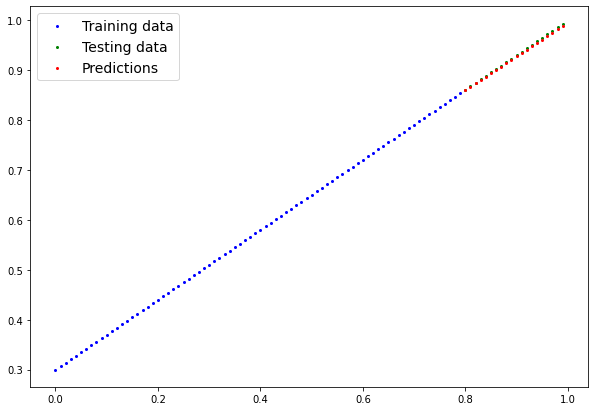

In [52]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

So what could it be?

Let's find out.

## 6. The missing piece: non-linearity

**'What patterns could you draw if you were given an infinite amount of a straight and non-straight lines ?'**
Or in meaching learning terms, how can we give it the capacity to draw non-straight (non-linear) lines?

Let's find out.

### 6.1 Recreating non-linear data (red and blue circles)

First, let's recreate the data to start off fresh. We'll use the same setup as before.

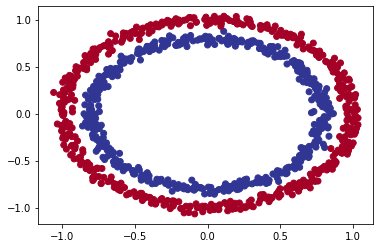

In [61]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_sample = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [62]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

- Linear = straight lines
- Non-Linear = non-straight lines  

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

PyTorch has a bunch of [ready-made non-linear activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, [torch.nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [63]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a popular non-linear activation function

  def forward(self, x: torch.Tensor) -> torch.Tensor:
     # Where should we put our non-linear activation functions?
     return self.layer_3(self.layer_2(self.relu(self.layer_1(x))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [64]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                        lr=0.1)

### 6.3 Training a model with non-linearity

In [65]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000
for epoch in range(epochs):
  # Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
  
  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, acc:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69441, acc:50.00% | Test loss: 0.00273, Test acc: 50.00%
Epoch: 100 | Loss: 0.68984, acc:52.38% | Test loss: 0.00273, Test acc: 51.00%
Epoch: 200 | Loss: 0.68707, acc:58.25% | Test loss: 0.00273, Test acc: 59.00%
Epoch: 300 | Loss: 0.68338, acc:53.87% | Test loss: 0.00273, Test acc: 58.00%
Epoch: 400 | Loss: 0.67826, acc:53.87% | Test loss: 0.00273, Test acc: 57.00%
Epoch: 500 | Loss: 0.67058, acc:53.25% | Test loss: 0.00273, Test acc: 58.00%
Epoch: 600 | Loss: 0.65828, acc:59.13% | Test loss: 0.00273, Test acc: 59.00%
Epoch: 700 | Loss: 0.63517, acc:71.75% | Test loss: 0.00273, Test acc: 75.00%
Epoch: 800 | Loss: 0.59027, acc:85.88% | Test loss: 0.00273, Test acc: 87.00%
Epoch: 900 | Loss: 0.51050, acc:94.12% | Test loss: 0.00273, Test acc: 90.50%


### 6.4 Evaluating a model trained with non-linear activation functions

Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [66]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

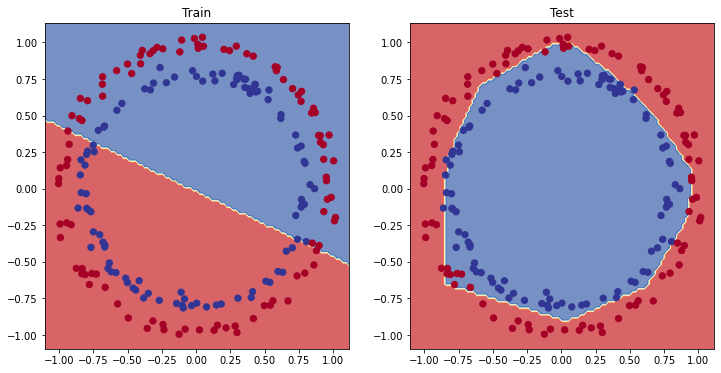

In [67]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_test, y_test) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**Challenge:** Can we improve model_3 to do better than 90% accuracy on the test data ?

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

In [68]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [69]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

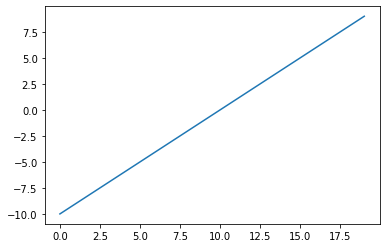

In [70]:
# Visualize the tensor
plt.plot(A)

A straight line, nice.

Now let's see how the ReLU activation function influences it.

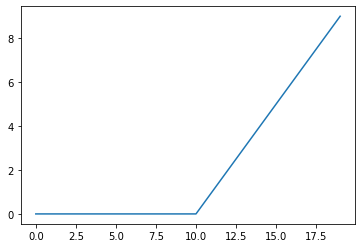

In [71]:
plt.plot(torch.relu(A))

In [72]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.relu(x)

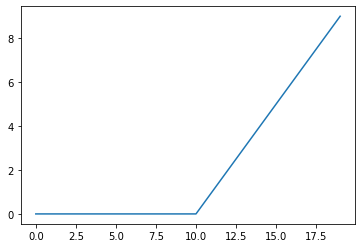

In [73]:
plt.plot(relu(A))

How about we try the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) we've been using?

In [74]:
# Now let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

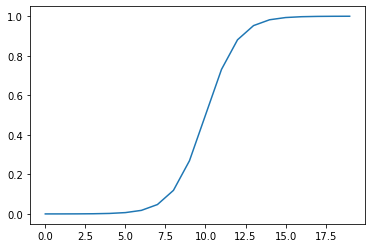

In [75]:
plt.plot(sigmoid(A))

Looking good! We've gone from a straight line to a curved line.

Now there's plenty more [non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that exist in PyTorch that we haven't tried.

But these two are two of the most common.

## 8. Putting it all together with a multi-class classification problem

- **Binary classification** = one thing or another (eg: cat or dog).
- **Multi-class classification** = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a multi-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [make_blobs()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

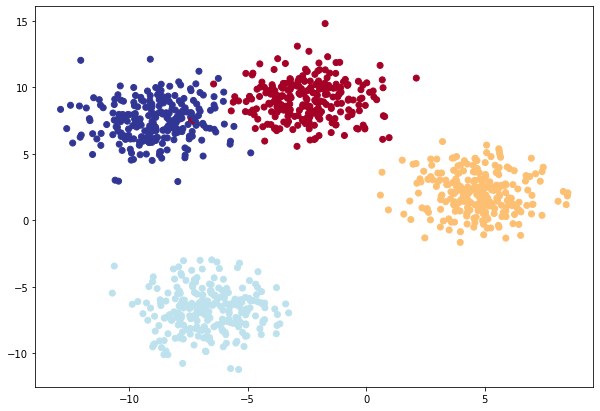

In [76]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_STATE)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # For multi-class classification target variable must have LongTensor as data type.

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_STATE)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

### 8.2 Building a multi-class classification model in PyTorch

In [78]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [79]:
# Build a multi-class clssification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of outputs features (number of output classes).
      hidden_units (int): Number of hidden units between layers, default 8


    Returns:

    Examples:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [80]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [81]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.



In [82]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()


# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter so we can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits(raw output of the model) -> Pred probs(use `torch.softmax`) -> Pred Labels(take the argmax of the prediction probabilities).

In [83]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [84]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [85]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [86]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [87]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

The index of the highest value is the class the model thinks the specific data sample most belongs to.

You can see the output of `torch.argmax()` returns 1, so for the features (`X`) of the sample at index 0, the model is predicting that the most likely class value (`y`) is 1.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

In [88]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [89]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [90]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train).to(device)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Evaluation
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test).to(device)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate loss/acc
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  ### Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, acc: 40.38% | Test loss: 1.07554, Test acc: 48.00%
Epoch: 10 | Loss: 0.64476, acc: 96.75% | Test loss: 0.66069, Test acc: 97.50%
Epoch: 20 | Loss: 0.42535, acc: 98.50% | Test loss: 0.43074, Test acc: 100.00%
Epoch: 30 | Loss: 0.25294, acc: 99.12% | Test loss: 0.24508, Test acc: 99.50%
Epoch: 40 | Loss: 0.11232, acc: 99.25% | Test loss: 0.10229, Test acc: 99.50%
Epoch: 50 | Loss: 0.06627, acc: 99.25% | Test loss: 0.05848, Test acc: 99.50%
Epoch: 60 | Loss: 0.05068, acc: 99.25% | Test loss: 0.04293, Test acc: 99.50%
Epoch: 70 | Loss: 0.04300, acc: 99.25% | Test loss: 0.03491, Test acc: 99.50%
Epoch: 80 | Loss: 0.03836, acc: 99.25% | Test loss: 0.02988, Test acc: 99.50%
Epoch: 90 | Loss: 0.03525, acc: 99.25% | Test loss: 0.02663, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.


In [91]:
# Making predictions
model_4.train()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [92]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [94]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).

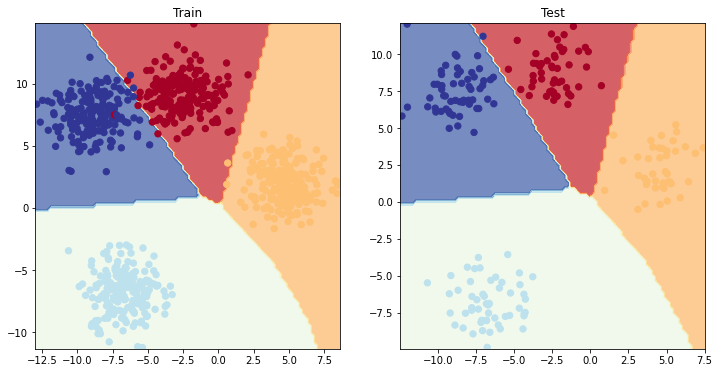

In [96]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate you classification model using more metrics such as the following:

- **Accuracy:** Out of 100 samples, how many does our model get right ? E.g. 95% accuracy means it gets 95/100 predictions correct.
- **Precision:** Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
- **Recall:** Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
- **F1-score:** Combines precision and recall into one metric. 1 is best, 0 is worst.
- **Confusion matrix:** Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).
- **Classification report:** Collection of some of the main classification metrics such as precision, recall and f1-score.

If you want to access a lot of PyTorch metrics, see TorchMetrics: https://torchmetrics.readthedocs.io/en/stable/

In [97]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 17.3 MB/s 


In [98]:
from torchmetrics import Accuracy

# Setup metrics
torchmetric_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')